In [1]:
import os

os.getcwd()

'/Users/leonard/Google Drive Active(leonard.ng.wt@gmail.com)/rsna'

In [2]:
import matplotlib.pyplot as plt
import cv2
import glob, pylab, pandas as pd
import numpy as np
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator

In [3]:
df_detailed = pd.read_csv('./stage_2_detailed_class_info.csv')

In [4]:
df_detailed.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [5]:
df_detailed['patientId'] =   df_detailed['patientId'].astype(str) + '.png' 

In [6]:
df_detailed.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6.png,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd.png,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb.png,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5.png,Normal
4,00436515-870c-4b36-a041-de91049b9ab4.png,Lung Opacity


In [7]:
image_gen = ImageDataGenerator(rotation_range = 30,
                              width_shift_range= 0.1, 
                              height_shift_range= 0.1,
                              rescale= 1/255,
                              shear_range=0.2,
                              zoom_range= 0.2,
                              horizontal_flip= True,
                              fill_mode='nearest',
                               validation_split =0.2
                              )

In [8]:
train_image_gen = image_gen.flow_from_dataframe(dataframe = df_detailed,
                             directory= './train',
                             x_col = 'patientId',
                             y_col = 'class',
                              target_size=(256,256),
                              color_mode='rgb',
                              classes= None,
                              class_mode='categorical',
                              batch_size=32,
                              shuffle=True,
                              subset = 'training'
                             )

Found 24015 validated image filenames belonging to 3 classes.


/Users/leonard/opt/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 209 invalid image filename(s) in x_col="patientId". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [9]:
test_image_gen = image_gen.flow_from_dataframe(dataframe = df_detailed,
                             directory= './train',
                             x_col = 'patientId',
                             y_col = 'class',
                              target_size=(256,256),
                              color_mode='rgb',
                              classes= None,
                              class_mode='categorical',
                              batch_size=32,
                              shuffle=True,
                              subset = 'validation'
                             )

Found 6003 validated image filenames belonging to 3 classes.


In [10]:
!pip install -U keras


Requirement already up-to-date: keras in /Users/leonard/opt/anaconda3/lib/python3.7/site-packages (2.4.3)


In [15]:
from tensorflow import keras

from keras.applications import InceptionV3

from keras import callbacks

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Conv3D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.models import Model


In [16]:
orig_net = InceptionV3(include_top=False, weights='imagenet', input_shape=(256,256,3)) 


87916544/87910968 [==============================] - 9s 0us/step


In [24]:
filters = GlobalAveragePooling2D()(orig_net.output) 


In [25]:
classifiers = Dense(3, activation='softmax', bias_initializer='ones')(filters)  

In [26]:
model = Model(inputs=orig_net.inputs, outputs=classifiers)  


In [27]:
model.compile(loss='categorical_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint = ModelCheckpoint("InceptionV3_1.h5", monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto',
                             period=1)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=20, 
                      verbose=1, 
                      mode='auto')

results = model.fit_generator(train_image_gen, epochs =150, 
                              steps_per_epoch=400,
                             validation_data=test_image_gen,  
                              callbacks=[checkpoint,early])

Epoch 1/150
400/400 [==============================] - ETA: 0s - loss: 0.7689 - accuracy: 0.6398
Epoch 00001: val_accuracy improved from -inf to 0.55872, saving model to InceptionV3_1.h5
400/400 [==============================] - 3279s 8s/step - loss: 0.7689 - accuracy: 0.6398 - val_loss: 0.8266 - val_accuracy: 0.5587
Epoch 2/150
400/400 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.6735
Epoch 00002: val_accuracy did not improve from 0.55872
400/400 [==============================] - 2919s 7s/step - loss: 0.7039 - accuracy: 0.6735 - val_loss: 1.1577 - val_accuracy: 0.5186
Epoch 3/150
400/400 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.6938
Epoch 00003: val_accuracy improved from 0.55872 to 0.56655, saving model to InceptionV3_1.h5
400/400 [==============================] - 3560s 9s/step - loss: 0.6692 - accuracy: 0.6938 - val_loss: 0.8637 - val_accuracy: 0.5666
Epoch 4/150
400/400 [==============================] - ETA: 0s - loss: 0

400/400 [==============================] - ETA: 0s - loss: 0.5673 - accuracy: 0.7473
Epoch 00028: val_accuracy did not improve from 0.70048
400/400 [==============================] - 3650s 9s/step - loss: 0.5673 - accuracy: 0.7473 - val_loss: 0.7479 - val_accuracy: 0.6802
Epoch 29/150
400/400 [==============================] - ETA: 0s - loss: 0.5733 - accuracy: 0.7448
Epoch 00029: val_accuracy did not improve from 0.70048
400/400 [==============================] - 3588s 9s/step - loss: 0.5733 - accuracy: 0.7448 - val_loss: 0.7213 - val_accuracy: 0.6715
Epoch 30/150
400/400 [==============================] - ETA: 0s - loss: 0.5636 - accuracy: 0.7519
Epoch 00030: val_accuracy did not improve from 0.70048
400/400 [==============================] - 3488s 9s/step - loss: 0.5636 - accuracy: 0.7519 - val_loss: 0.7424 - val_accuracy: 0.6488
Epoch 31/150
400/400 [==============================] - ETA: 0s - loss: 0.5630 - accuracy: 0.7502
Epoch 00031: val_accuracy did not improve from 0.70048
40

Epoch 57/150
400/400 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.7773
Epoch 00057: val_accuracy did not improve from 0.72081
400/400 [==============================] - 2998s 7s/step - loss: 0.5042 - accuracy: 0.7773 - val_loss: 0.7938 - val_accuracy: 0.6698
Epoch 58/150
400/400 [==============================] - ETA: 0s - loss: 0.4997 - accuracy: 0.7805
Epoch 00058: val_accuracy did not improve from 0.72081
400/400 [==============================] - 1747s 4s/step - loss: 0.4997 - accuracy: 0.7805 - val_loss: 0.8494 - val_accuracy: 0.6217
Epoch 59/150
400/400 [==============================] - ETA: 0s - loss: 0.4945 - accuracy: 0.7837
Epoch 00059: val_accuracy did not improve from 0.72081
400/400 [==============================] - 1750s 4s/step - loss: 0.4945 - accuracy: 0.7837 - val_loss: 0.7531 - val_accuracy: 0.6707
Epoch 60/150
400/400 [==============================] - ETA: 0s - loss: 0.4960 - accuracy: 0.7828
Epoch 00060: val_accuracy did not improve fr

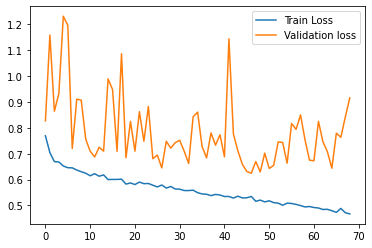

In [30]:
plt.plot(results.history["loss"], label='Train Loss')
plt.plot(results.history["val_loss"], label='Validation loss')
plt.legend();

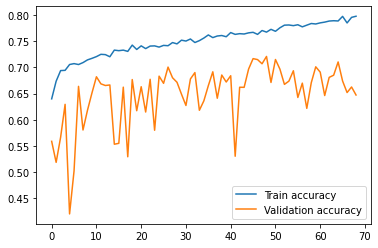

In [31]:
plt.plot(results.history["accuracy"], label='Train accuracy')
plt.plot(results.history["val_accuracy"], label='Validation accuracy')
plt.legend();